<a href="https://colab.research.google.com/github/bcmartinb/kilosort_spikeparam/blob/main/kilosort_spe_c42.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from pathlib import Path
import urllib.request
from tqdm import tqdm
import zipfile

drive_data_dir = Path('/content/drive/MyDrive/kilosort_data')
drive_data_dir.mkdir(parents=True, exist_ok=True)


## Setup

First make sure you are connected to a runtime with a GPU. Click `Runtime` in the File menu and click `Change runtime type` and set the Hardware Accelerator to be GPU.

### 1. Download example data

This is an example electrophysiological recording from the International Brain Laboratory, recorded using a Neuropixels 1.0 probe (all data [here](https://ibl.flatironinstitute.org/public/), note to use their full datasets you will need to decompress them with [`mtscomp`](https://github.com/int-brain-lab/mtscomp)). The full recording is over 4000 seconds long, and the cropped recording is 90 seconds long.

Downloading the cropped recording will take around 3 minutes in google colab. If it fails, please try again (press play again), it sometimes hangs.

You can alternatively use any bin file and upload to google drive to access in the notebook. (mount google drive, then look in `/content/drive/MyDrive/`).

### 2. Install kilosort and download probe maps

In [3]:

!pip install kilosort

In [4]:
# download channel maps for probes
from kilosort.utils import download_probes
download_probes()

100%|██████████| 555/555 [00:00<00:00, 679kB/s]
100%|██████████| 2.03k/2.03k [00:00<00:00, 2.58MB/s]
100%|██████████| 2.00k/2.00k [00:00<00:00, 2.64MB/s]


## Run kilosort

In [5]:
from kilosort import run_kilosort, DEFAULT_SETTINGS

settings = DEFAULT_SETTINGS.copy()
settings['data_dir'] = '/content/drive/MyDrive/kilosort_data/c42'
settings['n_chan_bin'] = 384

In [3]:
#REMEMBER TO COMMENT OUT THIS CELL AFTER RUNNING
"""
ops, st, clu, tF, Wall, similar_templates, is_ref, est_contam_rate, kept_spikes = \
    run_kilosort(settings=settings, probe_name='NeuroPix1_default.mat')"""


kilosort.run_kilosort: Kilosort version 4.0.38
INFO:kilosort.run_kilosort:Kilosort version 4.0.38
kilosort.run_kilosort: Python version 3.11.13
INFO:kilosort.run_kilosort:Python version 3.11.13
kilosort.run_kilosort: ----------------------------------------
INFO:kilosort.run_kilosort:----------------------------------------
kilosort.run_kilosort: System information:
INFO:kilosort.run_kilosort:System information:
kilosort.run_kilosort: Linux-6.1.123+-x86_64-with-glibc2.35 x86_64
INFO:kilosort.run_kilosort:Linux-6.1.123+-x86_64-with-glibc2.35 x86_64
kilosort.run_kilosort: x86_64
INFO:kilosort.run_kilosort:x86_64
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
INFO:kilosort.run_kilosort:Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA A100-SXM4-40GB 39.56GB
INFO:kilosort.run_kilosort:Using CUDA device: NVIDIA A100-SXM4-40GB 39.56GB
kilosort.run_kilosort: -----------------------

### Plot outputs of algorithm

You can also download the `kilosort4` folder with the outputs, and open it in [**phy**](https://github.com/cortex-lab/phy) to view the results.

load in outputs

In [11]:
import numpy as np
import pandas as pd
from pathlib import Path

# outputs saved to results_dir
results_dir = Path(settings['data_dir']).joinpath('kilosort4')
ops = np.load(results_dir / 'ops.npy', allow_pickle=True).item()
camps = pd.read_csv(results_dir / 'cluster_Amplitude.tsv', sep='\t')['Amplitude'].values
contam_pct = pd.read_csv(results_dir / 'cluster_ContamPct.tsv', sep='\t')['ContamPct'].values
chan_map =  np.load(results_dir / 'channel_map.npy')
templates =  np.load(results_dir / 'templates.npy')
chan_best = (templates**2).sum(axis=1).argmax(axis=-1)
chan_best = chan_map[chan_best]
amplitudes = np.load(results_dir / 'amplitudes.npy')
st = np.load(results_dir / 'spike_times.npy')
clu = np.load(results_dir / 'spike_clusters.npy')
firing_rates = np.unique(clu, return_counts=True)[1] * 30000 / st.max()
dshift = ops['dshift']

In [7]:
len(np.unique(clu))

345

plot outputs

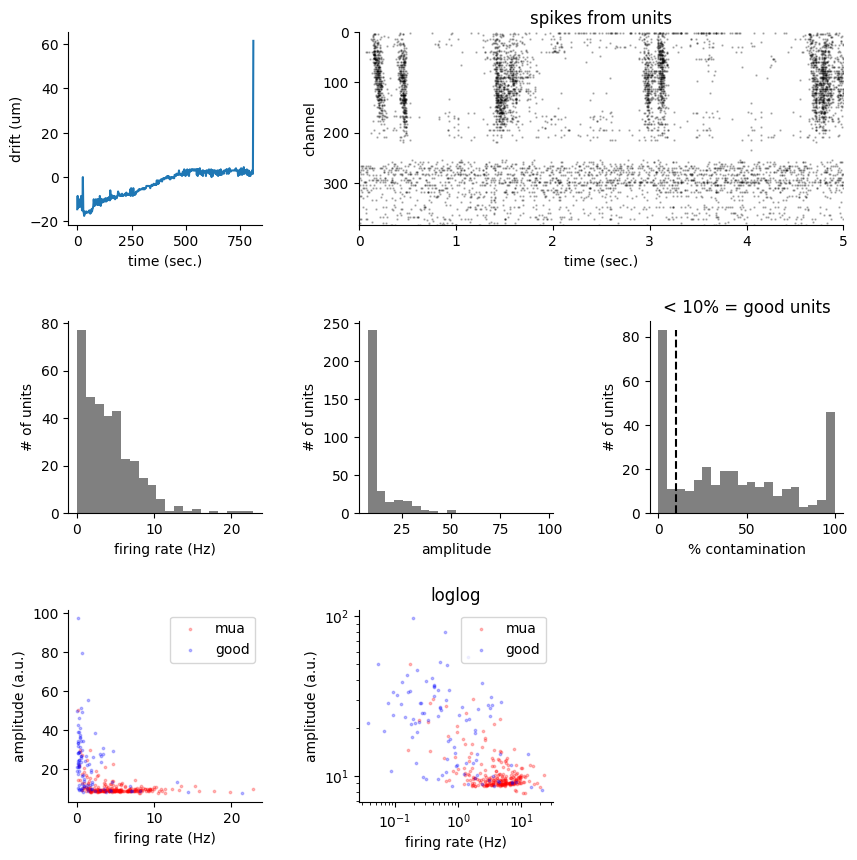

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec, rcParams
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
gray = .5 * np.ones(3)

fig = plt.figure(figsize=(10,10), dpi=100)
grid = gridspec.GridSpec(3, 3, figure=fig, hspace=0.5, wspace=0.5)

ax = fig.add_subplot(grid[0,0])
ax.plot(np.arange(0, ops['Nbatches'])*2, dshift);
ax.set_xlabel('time (sec.)')
ax.set_ylabel('drift (um)')

ax = fig.add_subplot(grid[0,1:])
t0 = 0
t1 = np.nonzero(st > ops['fs']*5)[0][0]
ax.scatter(st[t0:t1]/30000., chan_best[clu[t0:t1]], s=0.5, color='k', alpha=0.25)
ax.set_xlim([0, 5])
ax.set_ylim([chan_map.max(), 0])
ax.set_xlabel('time (sec.)')
ax.set_ylabel('channel')
ax.set_title('spikes from units')

ax = fig.add_subplot(grid[1,0])
nb=ax.hist(firing_rates, 20, color=gray)
ax.set_xlabel('firing rate (Hz)')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,1])
nb=ax.hist(camps, 20, color=gray)
ax.set_xlabel('amplitude')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,2])
nb=ax.hist(np.minimum(100, contam_pct), np.arange(0,105,5), color=gray)
ax.plot([10, 10], [0, nb[0].max()], 'k--')
ax.set_xlabel('% contamination')
ax.set_ylabel('# of units')
ax.set_title('< 10% = good units')

for k in range(2):
    ax = fig.add_subplot(grid[2,k])
    is_ref = contam_pct<10.
    ax.scatter(firing_rates[~is_ref], camps[~is_ref], s=3, color='r', label='mua', alpha=0.25)
    ax.scatter(firing_rates[is_ref], camps[is_ref], s=3, color='b', label='good', alpha=0.25)
    ax.set_ylabel('amplitude (a.u.)')
    ax.set_xlabel('firing rate (Hz)')
    ax.legend()
    if k==1:
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title('loglog')

~~~~~~~~~~~~~~ good units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


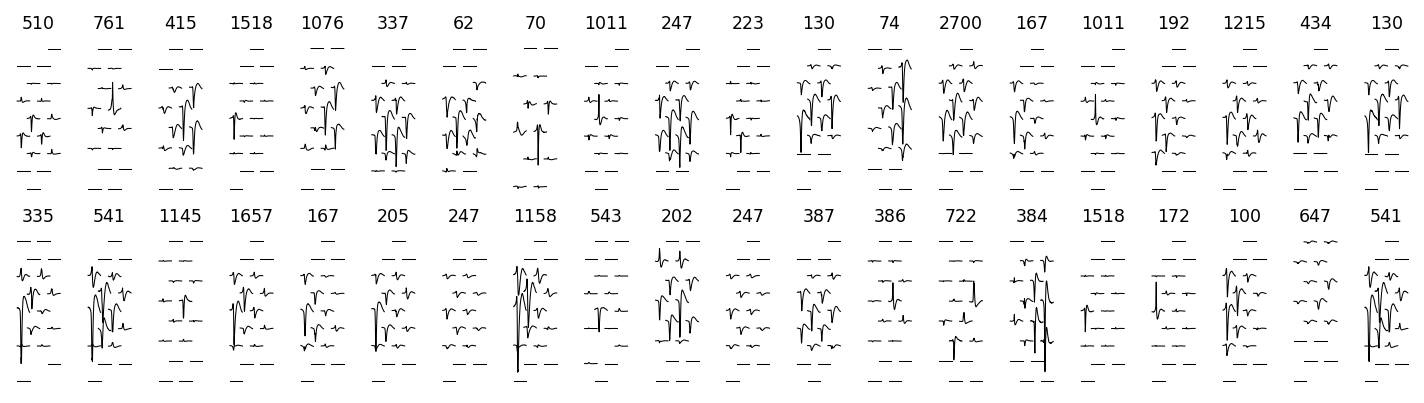

~~~~~~~~~~~~~~ mua units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


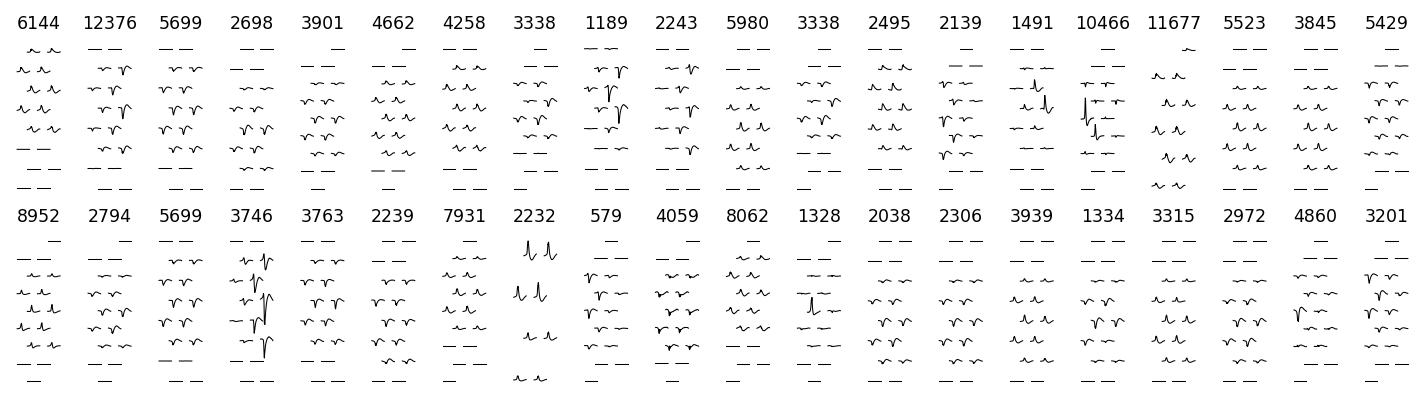

In [9]:
probe = ops['probe']
# x and y position of probe sites
xc, yc = probe['xc'], probe['yc']
nc = 16 # number of channels to show
good_units = np.nonzero(contam_pct <= 0.1)[0]
mua_units = np.nonzero(contam_pct > 0.1)[0]


gstr = ['good', 'mua']
for j in range(2):
    print(f'~~~~~~~~~~~~~~ {gstr[j]} units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('title = number of spikes from each unit')
    units = good_units if j==0 else mua_units
    fig = plt.figure(figsize=(12,3), dpi=150)
    grid = gridspec.GridSpec(2,20, figure=fig, hspace=0.25, wspace=0.5)

    for k in range(40):
        wi = units[np.random.randint(len(units))]
        wv = templates[wi].copy()
        cb = chan_best[wi]
        nsp = (clu==wi).sum()

        ax = fig.add_subplot(grid[k//20, k%20])
        n_chan = wv.shape[-1]
        ic0 = max(0, cb-nc//2)
        ic1 = min(n_chan, cb+nc//2)
        wv = wv[:, ic0:ic1]
        x0, y0 = xc[ic0:ic1], yc[ic0:ic1]

        amp = 4
        for ii, (xi,yi) in enumerate(zip(x0,y0)):
            t = np.arange(-wv.shape[0]//2,wv.shape[0]//2,1,'float32')
            t /= wv.shape[0] / 20
            ax.plot(xi + t, yi + wv[:,ii]*amp, lw=0.5, color='k')

        ax.set_title(f'{nsp}', fontsize='small')
        ax.axis('off')
    plt.show()

In [34]:


# Load and fix ops
ops_path = results_dir / 'ops.npy'
ops = np.load(ops_path, allow_pickle=True).item()

# Explicitly fix the filename fields
ops['data_file'] = '/content/drive/MyDrive/kilosort_data/c42/c42_npx_raw.bin'
ops['filename'] = '/content/drive/MyDrive/kilosort_data/c42/c42_npx_raw.bin'
ops['original_filename'] = '/content/drive/MyDrive/kilosort_data/c42/c42_npx_raw.bin'

# Save fixed ops
np.save(ops_path, ops)




In [35]:
from pathlib import Path
import numpy as np

results_dir = Path('/content/drive/MyDrive/kilosort_data/c42/kilosort4')
ops = np.load(results_dir / 'ops.npy', allow_pickle=True).item()

# Show keys to inspect
print("Keys in ops:", ops.keys())

# Print the file paths Kilosort is trying to use
print("original_filename:", ops.get('original_filename'))
print("data_dir:", ops.get('data_dir'))
print("data_file:", ops.get('data_file'))

# Reconstruct the path Kilosort will look for
expected_path = Path(ops.get('data_dir', '')) / ops.get('original_filename', '')
print("Expected full path:", expected_path)

# Check if file exists
print("File exists?", expected_path.exists())


Keys in ops: dict_keys(['n_chan_bin', 'fs', 'batch_size', 'nblocks', 'Th_universal', 'Th_learned', 'tmin', 'tmax', 'nt', 'shift', 'scale', 'artifact_threshold', 'nskip', 'whitening_range', 'highpass_cutoff', 'binning_depth', 'sig_interp', 'drift_smoothing', 'nt0min', 'dmin', 'dminx', 'min_template_size', 'template_sizes', 'nearest_chans', 'nearest_templates', 'max_channel_distance', 'max_peels', 'templates_from_data', 'n_templates', 'n_pcs', 'Th_single_ch', 'acg_threshold', 'ccg_threshold', 'cluster_neighbors', 'cluster_downsampling', 'max_cluster_subset', 'x_centers', 'duplicate_spike_ms', 'position_limit', 'data_dir', 'filename', 'settings', 'probe', 'data_dtype', 'do_CAR', 'invert_sign', 'NTbuff', 'Nchan', 'duplicate_spike_bins', 'torch_device', 'save_preprocessed_copy', 'xc', 'yc', 'kcoords', 'chanMap', 'n_chan', 'Nbatches', 'preprocessing', 'Wrot', 'fwav', 'runtime_preproc', 'usage_preproc', 'wPCA', 'wTEMP', 'yup', 'xup', 'ycup', 'xcup', 'iC', 'iC2', 'weigh', 'yblk', 'dshift', 'iK

In [36]:
cluster_id = get_good_cluster(results_dir, n=1)


mean_wv, spike_subset = mean_waveform(
    cluster_id,
    results_dir,
    n_spikes=100,
    bfile=None,   # let the function load it
    best=True
)

mean_temp = cluster_templates(
    cluster_id,
    results_dir,
    mean=True,
    best=True,
    spike_subset=spike_subset
)


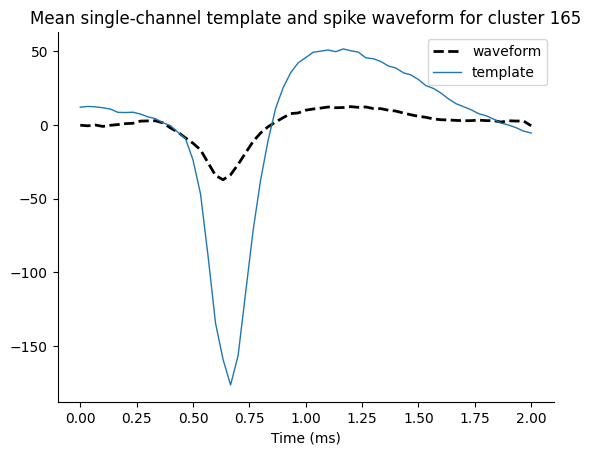

In [38]:

# Get time in ms for visualization
ops = load_ops(results_dir / 'ops.npy')
t = (np.arange(ops['nt']) / ops['fs']) * 1000

fig, ax = plt.subplots(1,1)
ax.plot(t, mean_wv, c='black', linestyle='dashed', linewidth=2, label='waveform')
ax.plot(t, mean_temp, linewidth=1, label='template')
ax.set_title(f'Mean single-channel template and spike waveform for cluster {cluster_id}')
ax.set_xlabel('Time (ms)')
ax.legend()


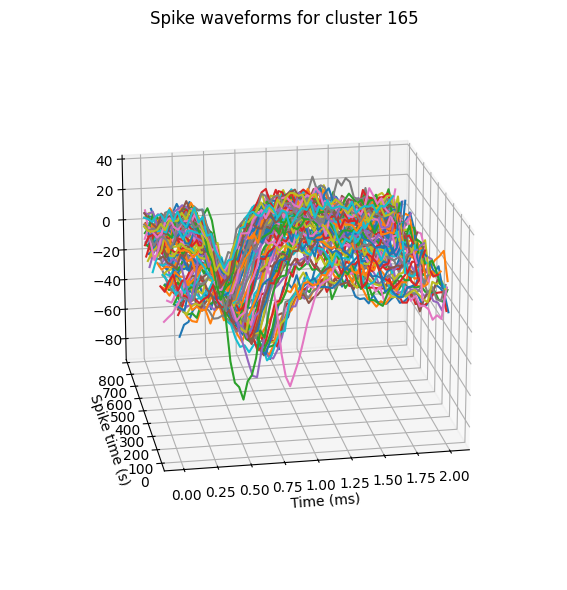

In [40]:
# Get n spike times for this cluster
spike_times, _ = get_cluster_spikes(cluster_id, results_dir, n_spikes=100)
# Time in s for spike time axis
t2 = spike_times / ops['fs']
# Get single-channel waveform for each spike
chan = get_best_channels(results_dir)[cluster_id]
waves = get_spike_waveforms(spike_times, results_dir, chan=chan)

# Plot each waveform, using spike time as 3rd dimension
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': '3d'})
for i in range(waves.shape[1]):
    # TODO: color by spike time
    ax.plot(t, t2[i], zs=waves[:,i], zdir='z');
ax.set_xlabel('Time (ms)');
ax.set_ylabel('Spike time (s)');
ax.view_init(azim=-100, elev=20);
ax.set_title(f'Spike waveforms for cluster {cluster_id}')
ax.set_box_aspect(None, zoom=0.85)

plt.tight_layout()

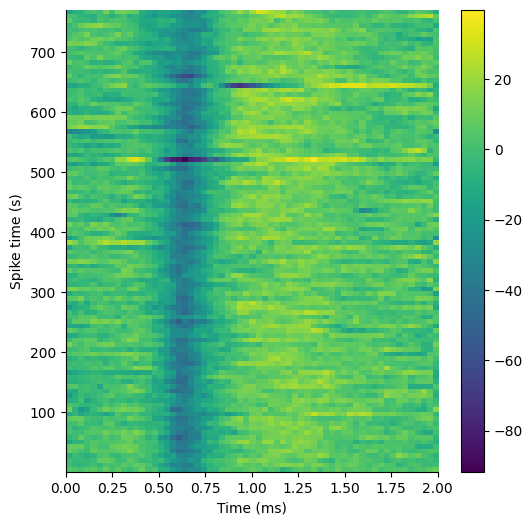

In [41]:

# Can also visualize this as a heatmap
fig2, ax2 = plt.subplots(1,1,figsize=(6,6))
pos = ax2.imshow(waves.T, aspect='auto', extent=[t[0], t[-1], t2[0], t2[-1]]);
fig2.colorbar(pos, ax=ax2);
ax2.set_xlabel('Time (ms)');
ax2.set_ylabel('Spike time (s)');